In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [2]:
import pandas as pd
import os

from linreg import *
from main import *
from bong.util import *
from bong.jobs_util import *
from bong.src import bbb, blr, bog, bong, experiment_utils


print(AGENT_TYPES)


['fg-bong', 'fg-l-bong', 'fg-rep-bong', 'fg-rep-l-bong', 'fg-blr', 'fg-bog', 'fg-rep-bog', 'fg-bbb', 'fg-rep-bbb']


In [3]:
parallel = False
args_df = read_job_args(parallel)
print(args_df)

query_dict = {'agent': 'fg-bong', 'learning_rate': 2.0, 'num_iter': 10}
jobname = get_job_name(args_df, query_dict)
print(jobname)


   dataset  key    agent  learning_rate  num_iter job-name
0   logreg    0  fg-bong            1.0        10   bong-0
1   logreg    0  fg-bong            1.0       100   bong-1
2   logreg    0   fg-blr            3.0        10  bong-10
3   logreg    0   fg-blr            3.0       100  bong-11
4   logreg    0  fg-bong            2.0        10   bong-2
5   logreg    0  fg-bong            2.0       100   bong-3
6   logreg    0  fg-bong            3.0        10   bong-4
7   logreg    0  fg-bong            3.0       100   bong-5
8   logreg    0   fg-blr            1.0        10   bong-6
9   logreg    0   fg-blr            1.0       100   bong-7
10  logreg    0   fg-blr            2.0        10   bong-8
11  logreg    0   fg-blr            2.0       100   bong-9
bong-2


In [4]:

results_dict = read_job_results(parallel)
print(results_dict.keys())
print(results_dict[jobname])

dict_keys(['bong-0', 'bong-1', 'bong-10', 'bong-11', 'bong-2', 'bong-3', 'bong-4', 'bong-5', 'bong-6', 'bong-7', 'bong-8', 'bong-9'])
   time  step    kl  nll  nlpd
0     0     0   0.0    0     0
1     0     1   2.0   10    10
2     0     2   4.0   20    20
3     0     3   6.0   30    30
4     0     4   8.0   40    40
5     0     5  10.0   50    50
6     0     6  12.0   60    60
7     0     7  14.0   70    70
8     0     8  16.0   80    80
9     0     9  18.0   90    90


In [60]:
from bong.agents import *


df = make_agent_df(AGENT_DICT)
df.head(n=50)

,constructor,needs_lr,needs_niter,needs_nsamples,linplugin,empirical_fisher,needs_rank,agent
0,<class 'bong.src.bong.fg_bong'>,False,False,True,False,True,False,bong-fc
1,<class 'bong.src.bong.fg_reparam_bong'>,False,False,True,False,True,False,bong-fc-mom
2,<class 'bong.src.bong.dg_bong'>,False,False,True,False,True,False,bong-diag
3,<class 'bong.src.bong.dg_reparam_bong'>,False,False,True,False,True,False,bong-diag-mom
4,<class 'bong.src.bong.dlrg_bong'>,False,False,True,False,True,True,bong-dlr
5,<class 'bong.src.blr.fg_blr'>,True,True,True,False,False,False,blr-fc
6,<class 'bong.src.blr.fg_reparam_blr'>,True,True,True,False,False,False,blr-fc-mom
7,<class 'bong.src.blr.dg_blr'>,True,True,True,False,True,False,blr-diag
8,<class 'bong.src.blr.dg_reparam_blr'>,True,True,True,False,True,False,blr-diag-mom
9,<class 'bong.src.blr.dlrg_blr'>,True,True,True,False,True,True,blr-dlr


In [38]:
from bong.agents import *

def convert_arg_dict_to_str(agent, args):
    str = f'--agent {agent} '
    for (k,v) in args.items():
        str = str + f'--{k} {v} '
    return str

def extract_args(props, learning_rate, num_iter, num_sample):
    args = {}
    if props['needs_lr']: args['learning_rate'] = learning_rate
    if props['needs_niter']: args['num_iter'] = num_iter
    if props['needs_nsamples']: args['num_samples'] = num_sample
    args['empirical_fisher'] = props['empirical_fisher'] 
    args['linplugin'] = props['linplugin']
    return args

def make_flags(agent, AGENT_DICT, lr, niter, nsample):
    props = AGENT_DICT[agent]
    args = extract_args(props, lr, niter, nsample)
    cmd = convert_arg_dict_to_str(agent, args)
    return cmd

lrs = [1,2,]
niters = [2,3]
nsamples = [4,5]
agents = ['bong-fc', 'bong-fc-lin',  'bbb-fc', 'bbb-fc-lin']
agent_with_flags = {}

for agent in agents:
    strings = [] # flags for each combination of hypers
    for lr in lrs:
        for niter in niters:
            for nsample in nsamples:
                strings.append(make_flags(agent, AGENT_DICT, lr, niter, nsample))
    unique_strings = set(strings)
    agent_with_flags[agent] = unique_strings



In [41]:
for (k,vs) in agent_with_flags.items():
    print(k, len(vs))
    for v in vs:
        print(v)

bong-fc 2
--agent bong-fc --num_samples 4 --empirical_fisher True --linplugin False 
--agent bong-fc --num_samples 5 --empirical_fisher True --linplugin False 
bong-fc-lin 1
--agent bong-fc-lin --empirical_fisher False --linplugin True 
bbb-fc 8
--agent bbb-fc --learning_rate 2 --num_iter 3 --num_samples 4 --empirical_fisher False --linplugin False 
--agent bbb-fc --learning_rate 1 --num_iter 3 --num_samples 4 --empirical_fisher False --linplugin False 
--agent bbb-fc --learning_rate 2 --num_iter 2 --num_samples 4 --empirical_fisher False --linplugin False 
--agent bbb-fc --learning_rate 1 --num_iter 2 --num_samples 4 --empirical_fisher False --linplugin False 
--agent bbb-fc --learning_rate 1 --num_iter 3 --num_samples 5 --empirical_fisher False --linplugin False 
--agent bbb-fc --learning_rate 2 --num_iter 3 --num_samples 5 --empirical_fisher False --linplugin False 
--agent bbb-fc --learning_rate 2 --num_iter 2 --num_samples 5 --empirical_fisher False --linplugin False 
--agent bbb-

In [41]:
# plots for each lr

def plot_vs_lr(args_df, results_dict):
    lrs = args_df['learning_rate'].unique()
    query_dict = {'agent': 'fg-bong', 'learning_rate': 2.0, 'num_iter': 10}
    jobname = get_jobname_from_args(args_df, query_dict)
    print(jobname)

    results_dict = read_job_results(parallel)
    print(results_dict.keys())
    print(results_dict[jobname])






  dataset  key    agent  learning_rate  num_iter job-name
0  logreg    0  fg-bong            1.0        10   bong-0
1  logreg    0   fg-blr            1.0        10   bong-1
2  logreg    0  fg-bong            2.0        10   bong-2
3  logreg    0   fg-blr            2.0        10   bong-3
4  logreg    0  fg-bong            3.0        10   bong-4
5  logreg    0   fg-blr            3.0        10   bong-5
bong-2


TypeError: read_job_results() got an unexpected keyword argument 'serial'

In [28]:
# Run main.py

import argparse
from functools import partial
from pathlib import Path
import time
import json
import pandas as pd
import jax.numpy as jnp
import numpy as np
import os

from main import *


parser = argparse.ArgumentParser()

# Data parameters
parser.add_argument("--dataset", type=str, default="logreg")
parser.add_argument("--key", type=int, default=0)

# Model parameters
parser.add_argument("--agent", type=str, default="fg-bong")
parser.add_argument("--learning_rate", type=float, default=0.01)
parser.add_argument("--num_iter", type=int, default=10) 


# results
cwd = os.getcwd()
parser.add_argument("--dir", type=str, default="")
parser.add_argument("--filename", type=str, default="")


args = parser.parse_args(args=[])
#args = parser.parse_args())

if args.filename == "":
        args.filename = f"{args.dataset}_{args.agent}_I{args.num_iter}"

print(args)

args_dict = extract_args_dict(args, parser)
print(args_dict)

main(args, args_dict)



Namespace(dataset='logreg', key=0, agent='fg-bong', learning_rate=0.01, num_iter=10, dir='', filename='logreg_fg-bong_I10')
{'dataset': 'logreg', 'key': 0, 'agent': 'fg-bong', 'learning_rate': 0.01, 'num_iter': 10, 'dir': '', 'filename': 'logreg_fg-bong_I10'}
Saving to logreg_fg-bong_I10_args.json
Saving to logreg_fg-bong_I10_results.csv


In [3]:

#python  bong/experiments/kpm_linreg.py  --debug True

#python  experiments/kpm_linreg.py  --agents fg-bong --filename "foo_bar"
#python  experiments/kpm_linreg.py  --agents fg-bong fg-l-bong fg-blr fg-bog fg-bbb
#python  experiments/kpm_linreg.py  --agents fg-rep-bong fg-rep-l-bong fg-rep-bog fg-rep-bbb

import argparse

parser = argparse.ArgumentParser()
    
parser.add_argument("--num_examples", type=int, default=500)
parser.add_argument("--param_dim", type=int, default=10)
parser.add_argument("--key", type=int, default=0)
parser.add_argument("--emission_noise", type=float, default=1.0)

# Model parameters
parser.add_argument("--agents", type=str, nargs="+",
                  default=["fg-bong"], choices=AGENT_TYPES)
parser.add_argument("--num_samples", type=int, nargs="+", 
                  default=[10,])

parser.add_argument("--learning_rate", type=float, nargs="+", 
              default=[0.01])
parser.add_argument("--num_iter", type=int, nargs="+", 
              default=[10])
parser.add_argument("--tune_learning_rate", type=bool, default=False)
parser.add_argument("--debug", type=bool, default=False)
parser.add_argument("--filename", type=str, default="")



#https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook
#args = parser.parse_args()
args = parser.parse_args(args=[])
print(args)

#main(args)#


Namespace(num_examples=500, param_dim=10, key=0, emission_noise=1.0, agents=['fg-bong'], num_samples=[10], learning_rate=[0.01], num_iter=[10], tune_learning_rate=False, debug=False, filename='')


In [39]:
import pandas as pd

# Sample DataFrame
data = {
    'A': [1, 1, 2, 2, 1, 1, 2, 2],
    'B': [1, 2, 1, 2, 1, 2, 1, 2],
    'C': [1, 1, 1, 1, 2, 2, 2, 2]
}

df = pd.DataFrame(data)

# Filter conditions stored in a dictionary
conditions = {'A': 1, 'B': 2}

# Apply filter using Boolean Indexing
mask = pd.Series(True, index=df.index)
for column, value in conditions.items():
    mask = mask & (df[column] == value)

filtered_df = df[mask]
print(filtered_df)

# Using query by dynamically creating a query string from the dictionary
query_str = ' & '.join([f"{k}=={v}" for k, v in conditions.items()])
filtered_df = df.query(query_str)
print(filtered_df)

from functools import reduce

# Apply filter using reduce to combine Boolean masks
filtered_df = df[reduce(lambda x, y: x & y, [(df[k] == v) for k, v in conditions.items()])]

print(filtered_df)

   A  B  C
1  1  2  1
5  1  2  2
   A  B  C
1  1  2  1
5  1  2  2
   A  B  C
1  1  2  1
5  1  2  2


In [5]:
import os
root = os.getcwd()
#root = "/Users/kpmurphy/github/bong/bong"
curr_path = Path(root, "results")
print(curr_path)

if args.filename == "":
    filename_prefix =  f"linreg_dim{args.param_dim}"
else:
    filename_prefix = args.filename
print("Saving results to", curr_path)
curr_path.mkdir(parents=True, exist_ok=True)

/teamspace/studios/this_studio/results
Saving results to /teamspace/studios/this_studio/results


In [6]:
data, subkey = make_data(args)
init_kwargs, callback = init(args, data)
prior, post = compute_prior_post(args, data)
 

agent_queue, subkey = make_agent_queue(subkey, args, init_kwargs, None, data['X_tr'], data['Y_tr'])
result_dict = {}
result_dict['laplace'] = (10.0, 1.0, 2.0, 3.0)
result_dict = run_agents(subkey, agent_queue, data, callback, result_dict)






Running fg-bong-M10-I1-LR0...
	KL-Div: 0.0844, Time: 1.51s


In [127]:
print(result_dict)

{'laplace': (10.0, 1.0, 2.0, 3.0), 'fg-bong-M10-I1-LR0': (0.4651384169701487, Array([22.950815  , 23.836744  , 23.086971  , 22.62736   , 22.643894  ,
       23.653706  , 23.81697   , 23.206947  , 22.475372  , 21.49679   ,
       21.558895  , 22.801449  , 18.805405  , 15.997734  , 14.256347  ,
       14.280935  , 14.002972  , 13.844494  , 13.763961  , 13.119299  ,
       13.120931  , 13.138289  , 13.091949  , 12.731443  , 11.946014  ,
       12.070639  , 12.2719755 , 12.154854  , 11.480072  , 11.429003  ,
       11.424678  , 11.174073  , 10.927644  , 11.577087  , 11.491255  ,
       12.533128  , 12.389325  , 12.312702  , 12.25417   , 12.438559  ,
       12.502064  , 12.477814  , 12.456735  , 12.404019  , 12.179851  ,
       11.335275  , 10.502107  , 10.637063  , 10.50477   , 10.513651  ,
       10.346122  , 10.300872  , 10.222781  ,  9.984198  , 10.002081  ,
        9.934994  ,  9.873008  ,  9.682464  ,  9.132798  ,  9.035919  ,
        8.946268  ,  9.195013  ,  9.117326  ,  9.591936  ,

In [183]:
fname = "/Users/kpmurphy/github/bong/bong/results/baz_parsed.csv"
df = pd.read_csv(fname)
df.tail()



,prefix,M,I,LR,name,step,kl,nll,nlpd,time
13496,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,495,NaN,NaN,NaN,1.861322
13497,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,496,NaN,NaN,NaN,1.861322
13498,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,497,NaN,NaN,NaN,1.861322
13499,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,498,NaN,NaN,NaN,1.861322
13500,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,499,NaN,NaN,NaN,1.861322


In [188]:
def make_marker(name):
    #https://matplotlib.org/stable/api/markers_api.html
    markers = {'bong': 'o', 'blr': 's', 'bog': 'x', 'bbb': '*'}
    if "bong" in name:
        return markers['bong']
    elif "blr" in name:
        return markers['blr']
    elif "bog" in name:
        return markers['bog']
    elif "bbb" in name:
        return markers['bbb']
    else:
        return 'P;'

500


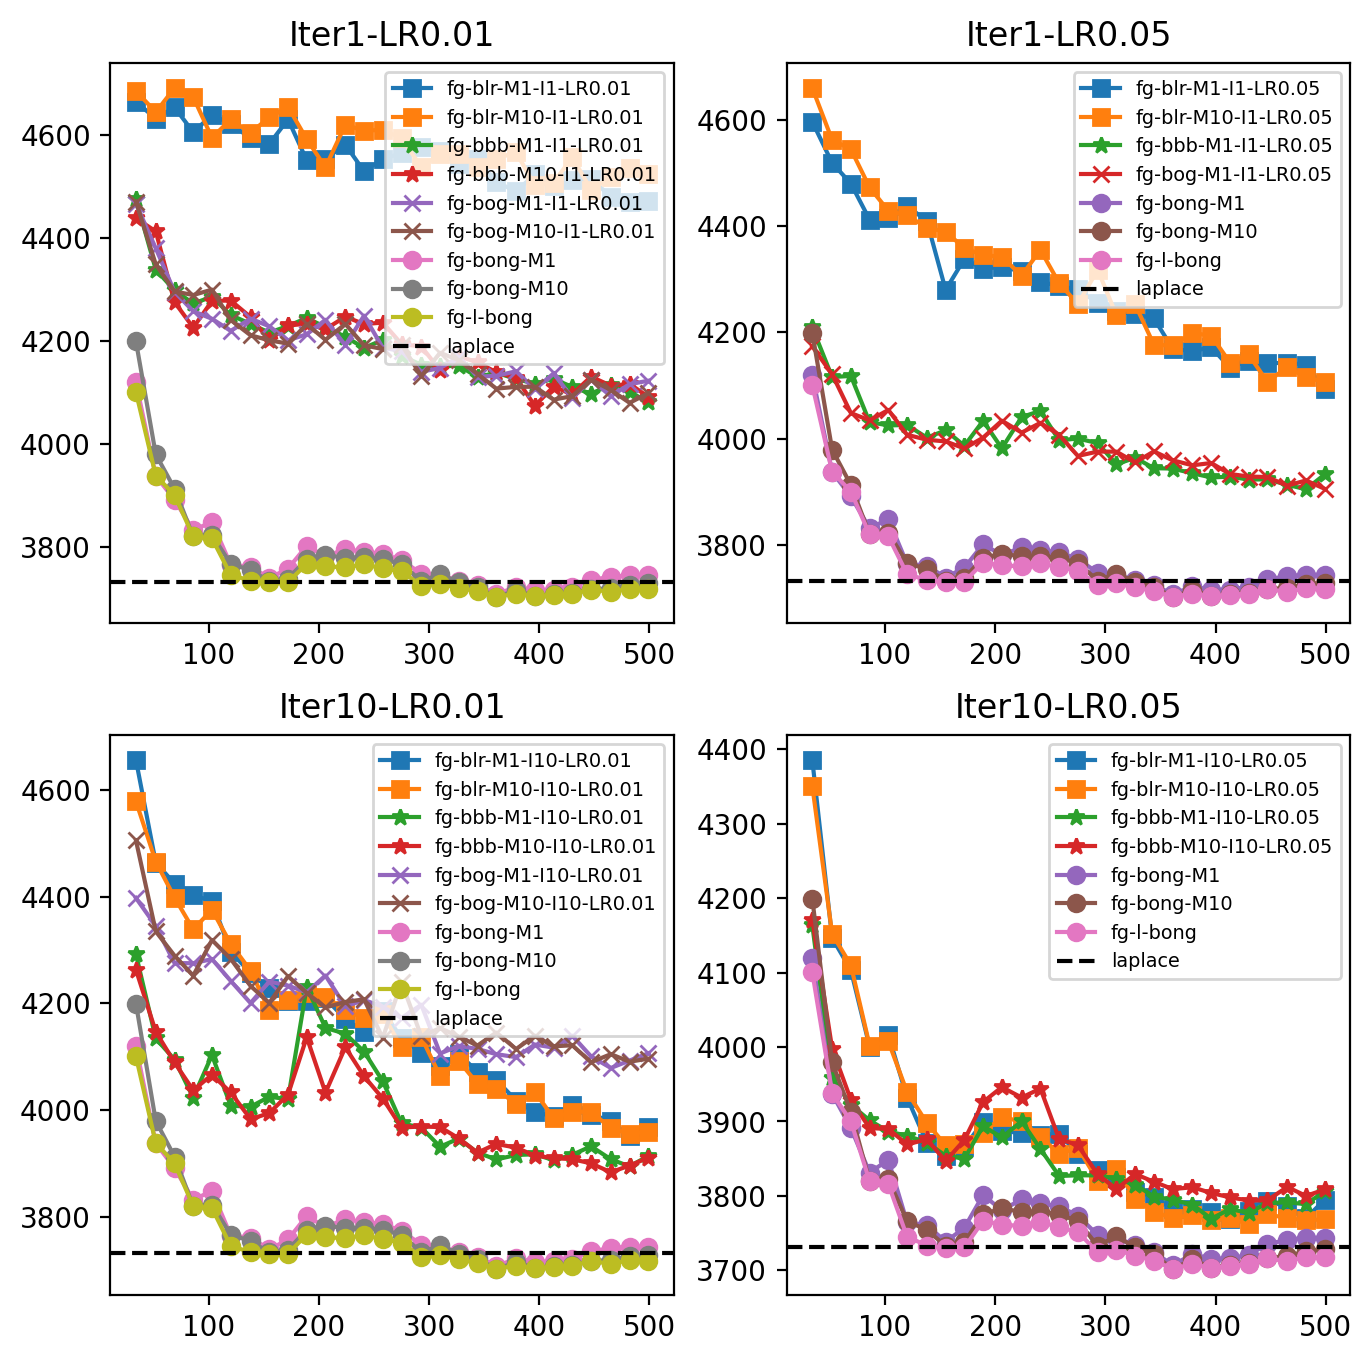

In [198]:

niters = df['I'].unique()
niters = niters[niters != 0]

lrs = df['LR'].unique()
lrs = lrs[lrs != 0]

mcs = df['M'].unique()
mcs = mcs[mcs != 0]

agents = df['prefix'].unique()
agents = agents[ agents != "laplace" ]
agents = agents[ agents != "fg-bong" ]
agents = agents[ agents != "fg-l-bong" ]

fs = 'x-small'
loc = 'upper right' #'lower left'

df2 = df[ df['prefix']=='fg-l-bong']
kl = df2['kl'].to_numpy()
T = len(kl)
print(T)

# extract subset of points for plotting to avoid cluttered markers
#ndx = jnp.array(range(0, T, 10)) # decimation of points 
ndx = round(jnp.linspace(0, T-1, num=min(T,30)))
# skip first 2 time steps, since it messes up the vertical scale
ndx = ndx[2:]

fig, axs = plt.subplots(len(niters), len(lrs), figsize=(8, 8))
for i, niter in enumerate(niters):
    for j, lr in enumerate(lrs):
        ax = axs[i,j]
        df2 = df[ (df['I']==niter) & (df['LR']==lr) ]
        for agent in agents:
            df3 = df2[df2['prefix']==agent]
            for mc in mcs:
                df4 = df3[ (df3['M']==mc) ]
                name = f'{agent}-M{mc}-I{niter}-LR{lr}'
                #print(name)
                steps = df4['step'].to_numpy()
                kl = df4['kl'].to_numpy()
                if np.any(np.isnan(kl)):
                    continue
                else:
                  ax.plot(steps[ndx], kl[ndx], label=name, marker=make_marker(agent))

        if 'fg-bong' in df['prefix'].unique():
            agent = 'fg-bong' # not indexed by I,LR
            df2 = df[ (df['prefix']==agent) ]
            for mc in mcs:
                df3 = df2[ (df2['M']==mc) ]
                name = f'{agent}-M{mc}'
                steps = df3['step'].to_numpy()
                kl = df3['kl'].to_numpy()
                ax.plot(steps[ndx], kl[ndx], label=name, marker=make_marker(agent))
        
        if 'fg-l-bong' in df['prefix'].unique():
            agent = 'fg-l-bong' # not indexed by I,LR,M
            df2 = df[df['prefix']==agent]
            name = f'{agent}'
            steps = df2['step'].to_numpy()
            kl = df2['kl'].to_numpy()
            ax.plot(steps[ndx], kl[ndx], label=name, marker=make_marker(agent))
        
        if 'laplace' in df['prefix'].unique():
            df2 = df[ (df['prefix']=='laplace') ]
            kldiv = df2['kl'].to_numpy()[0]
            ax.axhline(kldiv, color="black", linestyle="--", label='laplace')

        ax.legend(loc=loc, prop={'size': fs})
        ax.set_title(f'Iter{niter}-LR{lr}')

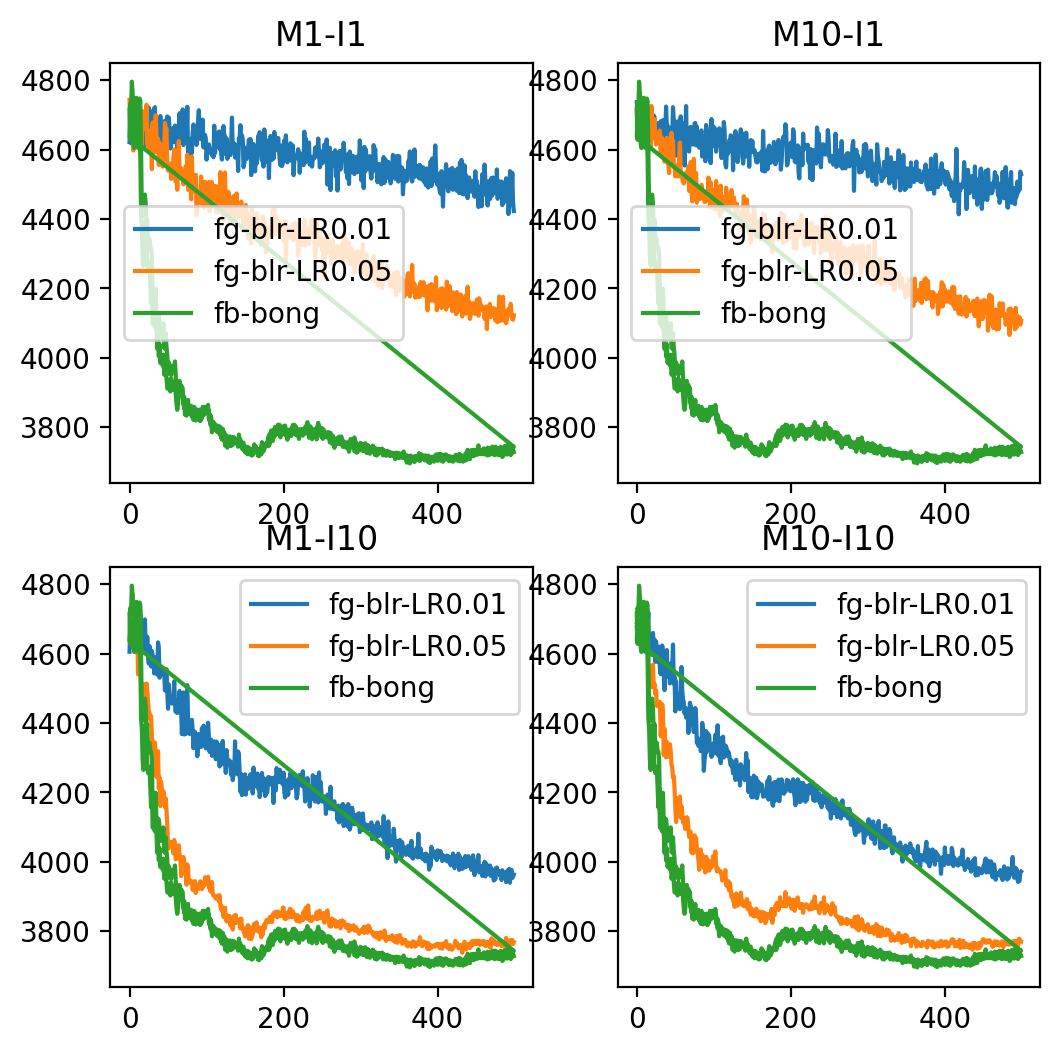

In [154]:


niters = df['I'].unique()
niters = niters[niters != 0]

mcs = df['M'].unique()
mcs = mcs[mcs != 0]

lrs = df['LR'].unique()
lrs = lrs[lrs != 0]


fig, axs = plt.subplots(len(niters), len(mcs), figsize=(6, 6))
for i, niter in enumerate(niters):
    for m, mc in enumerate(mcs):
        ax = axs[i,m]
        dfsub = df[ (df['I']==niter) & (df['M']==mc) ]
        for agent in agents:
            for lr in lrs:
                dfsub2 = dfsub[ (dfsub['prefix']==agent) & (dfsub['LR']==lr) ]
                ax.plot(dfsub2['step'], dfsub2['kl'], label=f'{agent}-LR{lr}')

        if 'fg-bong' in df['prefix'].unique():
            dfsub2 = df[ (df['prefix']=='fg-bong') ]
            ax.plot(dfsub2['step'], dfsub2['kl'], label=f'fb-bong')

        if 'laplace' in df['prefix'].unique():
            dfsub2 = df[ (df['prefix']=='laplace') ]
            #ax.plot(dfsub2['step'], dfsub2['kl'], label=f'fb-bong')

        ax.legend()
        ax.set_title(f'M{mc}-I{niter}')


In [145]:
niter,mc=10,10
dfsub = df[ (df['I']==niter) & (df['M']==mc) ]
print(dfsub)

      prefix   M   I    LR                   name  step         kl       nll  \
3501  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     0  4676.8800  0.829247   
3502  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     1  4638.6110  0.830271   
3503  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     2  4711.2515  0.831777   
3504  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     3  4733.3030  0.832249   
3505  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     4  4655.0474  0.833845   
...      ...  ..  ..   ...                    ...   ...        ...       ...   
4996  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   495  3755.1707  0.671016   
4997  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   496  3777.9292  0.669536   
4998  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   497  3777.8990  0.669020   
4999  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   498  3770.8887  0.668353   
5000  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   499  3770.4026  0.668435   

          nlpd      time  
3501  1.0114